 

# Spatial Interpolation

----------------

```{admonition} Learning Objectives
* Conduct various types of interpolation on point dataset
* Obtain interpolated values at specified unsampled locations
```
```{admonition} Review
* [Spatial Vector Data](c_vectors.md)
* [Attributes & Indexing for Vector Data](e_attributes.md)
* [Creating Spatial Vector Data](c_new_vectors.md)
* [Merge Data & Dissolve Polygons](e_vector_merge_dissolve.md)
```

----------------

Interpolation is the process of using locations with known, sampled values (of a phenomenon) to estimate the values at unknown, unsampled areas [^bolstad]. In this chapter, we will explore three interpolation methods: Thiessen polygons (Voronoi diagrams), k-nearest neighbors (KNN), and kriging.

We will first begin by importing modules (click the + below to show code cell).

In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

We will utilize shapefiles of San Francisco Bay Area county boundaries and rainfall "values" that were "sampled" in the Bay Area. We will load in the data and reproject the data (click the + below to show code cell).


```{Note} It is critical to use a 'projected' coordinate system when doing interpolation. If you keep your data in geographic lat lon distances will vary significantly as you move up and down in latitude... since interpolation depends on distance as a way of establishing relationships this would be a problem... a big one. 
```

In [2]:
# Load data

# County boundaries
# Source: https://opendata.mtc.ca.gov/datasets/san-francisco-bay-region-counties-clipped?geometry=-125.590%2C37.123%2C-119.152%2C38.640
counties = gpd.read_file("../_static/e_vector_shapefiles/sf_bay_counties/sf_bay_counties.shp")

# Rainfall measurement "locations"
# Source: https://earthworks.stanford.edu/catalog/stanford-td754wr4701
# Modified by author by clipping raster to San Francisco Bay Area, generating random points, and extracting raster values (0-255) to the points
rainfall = gpd.read_file("../_static/e_vector_shapefiles/sf_bay_rainfall/sf_bay_rainfall.shp")

# Reproject data to CA Teale Albert
# https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "
counties = counties.to_crs(proj)
rainfall = rainfall.to_crs(proj)

Next, we'll prepare the data for geoprocessing (click the + below to show code cell).

In [3]:
# Get X and Y coordinates of rainfall points
x_rain = rainfall["geometry"].x
y_rain = rainfall["geometry"].y

# Create list of XY coordinate pairs
coords_rain = [list(xy) for xy in zip(x_rain, y_rain)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_rain = list(rainfall["VALUE"])

# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

We will also define a function for exporting rasters.

In [4]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

With any model used for prediction, it is important to assess the model fit for unobserved locations (or the accuracy of the values predicted by the model in relation to their actual values). Thus, in order to assess the fit, we break our data into two portions, a "training" data set used to train the model, and a "testing" set that remains "unseen" by the model but can be used to assess model performance. Effectively, we can use this "unseen" testing subset to validate the model because we can compare their true values with the estimated value from the model prediction.

We will separate our rainfall dataset into two subsets: one for training and the other for testing. These subsets will be used in our KNN and kriging analyses.

In [5]:
# Split data into testing and training sets
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_rain, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj)
rain_train_gdf["Actual_Value"] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)
rain_test_gdf["Actual_Value"] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

Let's plot our data!

Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Measurement Locations')

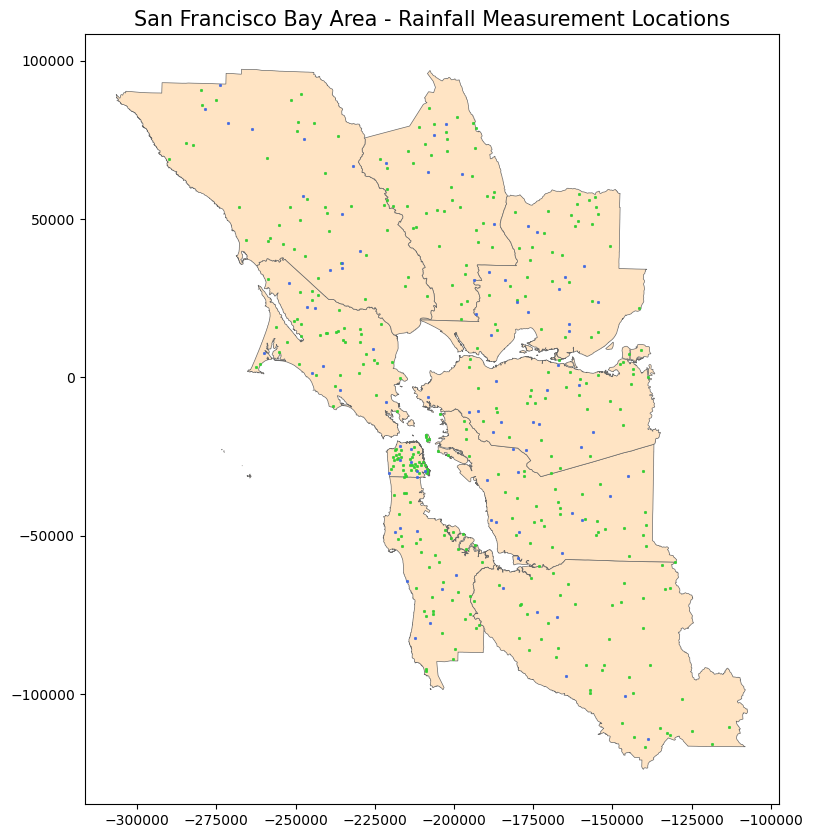

In [6]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In the map above, the green and blue points are the rainfall points that we loaded separated into the training set and testing set, respectively.

## Thiessen Polygons (Voronoi Diagrams)

Thiessen polygons (also known as Voronoi diagrams) polygons allow us to perform nearest neighbor interpolation, which is perhaps the most basic type of interpolation. Thiessen polygons are be constructed around each sampled point so all the space within a specific polygon is closest in distance to that sampled point (as compared to other sampled points). Then, to perform nearest neighbor interpolation, all that space is assigned the value of that sampled point. [^bolstad]

We can use the [`scipy` package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html) to create Thiessen polygons. After running the `Voronoi()` function, we can use the `vertices` attribute to get a list of vertices, which we can subsequently use to generate polygons.

```{attention} When creating Thiessen polygons, the sample points toward the edges of the point shapefile's extent will have infinite Voronoi regions, because not all sides of these edge points have adjacent sample points that would constrain the regions. Consequently, these infinite regions will not be exported. To mitigate this issue, we can create dummy points well beyond the extent of our datasets, which will create finite Voronoi regions for all of our actual sample points. Then, we can clip the regions to our extent shapefile (creating dummy points far away from our actual sample points will ensure the dummy points and their infinite Voronoi regions do not interfere with the sample points and their associated finite Voronoi regions after all regions are clipped).
```

In [7]:
# Extend extent of counties feature by using buffer
counties_buffer = counties.buffer(100000)

# Get extent of buffered input feature
min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = counties_buffer.total_bounds

# Use extent to create dummy points and add them to list of coordinates
coords_tp = coords_rain_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                 [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

# Compute Voronoi diagram
tp = Voronoi(coords_tp)

# Create empty list of hold Voronoi polygons
tp_poly_list = []

# Create a polygon for each region
# 'regions' attribute provides a list of indices of the vertices (in the 'vertices' attribute) that make up the region
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
for region in tp.regions:

    # Ignore region if -1 is in the list (based on documentation)
    if -1 in region:

        # Return to top of loop
        continue

    # Otherwise, pass
    else:
        pass

    # Check that region list has values in it
    if len(region) != 0:

        # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # Append polygon to list
        tp_poly_list.append(tp_poly_region)

    # If no values, return to top of loop
    else:
        continue

# Create GeoDataFrame from list of polygon regions
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = proj)

# Clip polygon regions to the counties boundary
tp_polys_clipped = gpd.clip(tp_polys, counties_dissolved)

A spatial join can be conducted to assign the rainfall training "values" to its associated Thiessen polygon.

In [8]:
# If rainfall point within the polygon, assign that rainfall value to the polygon
tp_polys_clipped_values = gpd.sjoin(rain_train_gdf, tp_polys_clipped, how = "right", op = 'within')

# Drop un-needed column
tp_polys_clipped_values = tp_polys_clipped_values.drop("index_left", axis = 1)

# Rename column
tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": "VALUE_Thiessen"})

# Display head of attribute table
print("Attribute Table: Thiessen Polygon Interpolated Values")
display(tp_polys_clipped_values.head())

Attribute Table: Thiessen Polygon Interpolated Values


/home/mmann1123/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,VALUE_Thiessen,geometry
13,31,"POLYGON ((-138976.334 -112365.094, -136050.399..."
29,56,"POLYGON ((-206051.365 -86531.722, -205209.852 ..."
30,42,"POLYGON ((-175950.824 -82651.951, -171865.597 ..."
28,58,"POLYGON ((-205209.852 -86150.045, -198923.353 ..."
184,37,"POLYGON ((-183161.675 -76937.990, -175852.000 ..."


A second spatial join can be conducted to assign those values from the Thiessen polygons to the points from the testing dataset (only if a test point falls within a polygon). We can subsequently get the out-of-sample r-squared value, which is calculated by using the data points that the model did not use (the testing dataset) and comparing the testing dataset's actual values to the values as predicted by the model.

In [9]:
# If test point is within a polygon, assign that polygon's value to the test point
rain_test_pred_tp = gpd.sjoin(rain_test_gdf, tp_polys_clipped_values, how = "left", op = 'within')

# Drop un-needed column
rain_test_pred_tp = rain_test_pred_tp.drop("index_right", axis = 1)

# Rename column
rain_test_pred_tp = rain_test_pred_tp.rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Thiessen": "VALUE_Predict"})

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_pred_tp.VALUE_Actual, rain_test_pred_tp.VALUE_Predict)
print("Thiessen polygon out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method")
display(rain_test_pred_tp.head(2))

Thiessen polygon out-of-sample r-squared: 0.89

Attribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method


/home/mmann1123/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geometry,VALUE_Actual,VALUE_Predict
0,POINT (-229633.026 40063.754),56,62
1,POINT (-273849.350 92453.689),73,91


Plotting the data, we see that each polygon has one green training point (and vice-versa). All space within one polygon is closest to the known training point (green dot) within the polygon. The testing points (blue dots) are assigned the value of the Thiessen polygon in which it falls.

Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Measurement Locations & Thiessen Polygons')

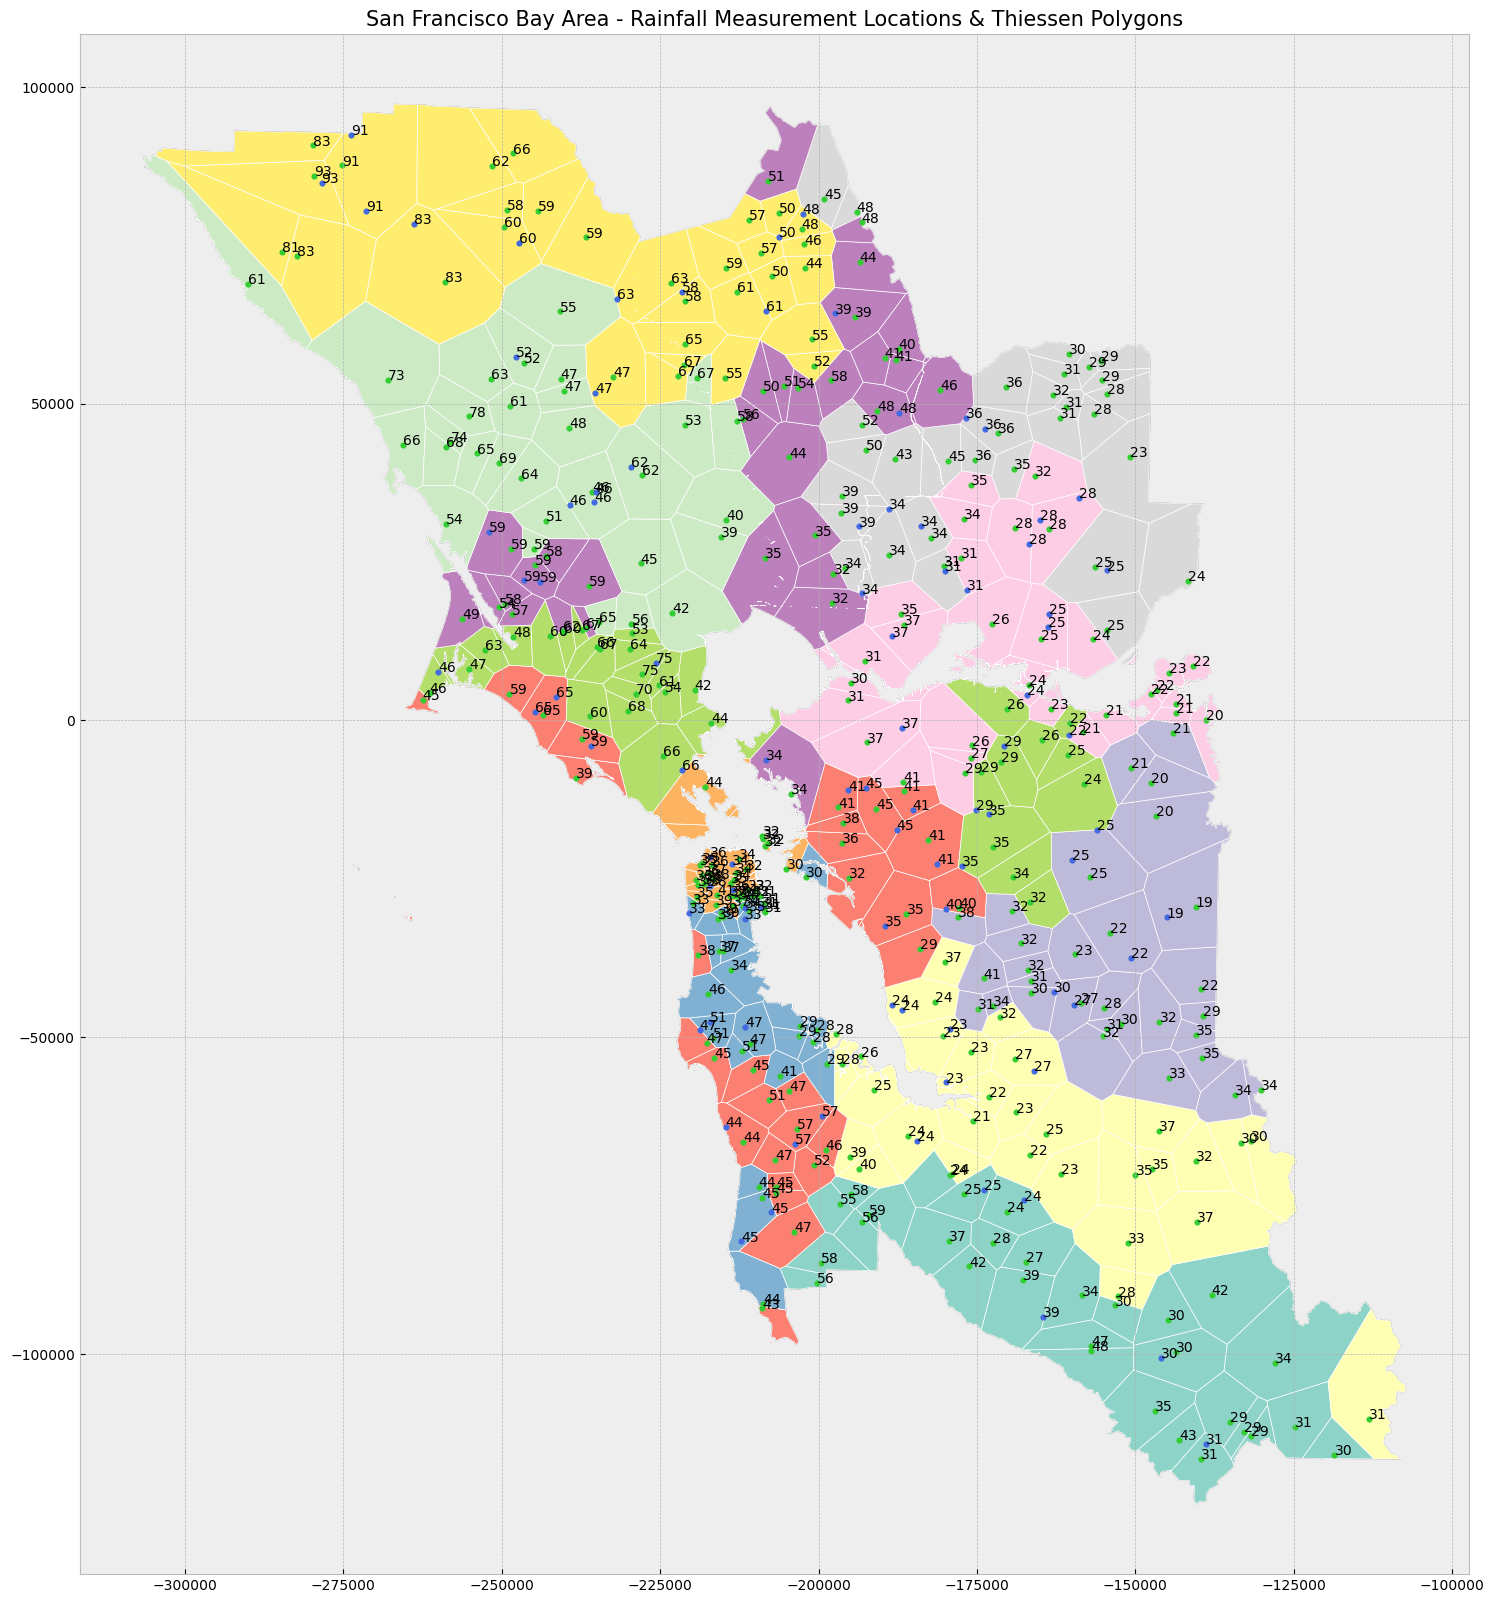

In [10]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 20))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
tp_polys_clipped.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
rain_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 15)

# Iterate through each rainfall train point to add a label with its value to the plot
for index, row in rain_train_gdf.iterrows():
    plt.annotate(row.Actual_Value, (row.geometry.x, row.geometry.y))

# Iterate through each rainfall test point to add a label with its value to the plot
for index, row in rain_test_pred_tp.iterrows():
    plt.annotate(row.VALUE_Predict, (row.geometry.x, row.geometry.y))

# Set title
ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations & Thiessen Polygons', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In addition to `vertices`, there are a few other attributes we can call if we want to further explore the polygons. These attributes will provide actual values (e.g., vertices) or provide the indices for querying other attributes. [^scipy_voronoi]

In the example below, we demonstrate how to extract the value of one of the Thiessen polygons at a new location for which we want a predicted value. We use the `point_region` attribute to provide the index of a point's Voronoi region, and we use that index to get the region in `regions`. That provides indices of the vertices that make up the polygon, which we use to get the appropriate values in `vertices`.

In [11]:
# Set index for feature of interest
feature_index_one = 5

# Get a Voronoi polygon for one feature
# 'point_region' attribute provides the index of the Voronoi region belonging to a specified point
# Can use the index to call the appropriate element in the 'regions' attribute
tp_poly_region_one = Polygon(tp.vertices[tp.regions[tp.point_region[feature_index_one]]])

# Create GeoDataFrame for polygon
tp_poly_region_one = gpd.GeoDataFrame([tp_poly_region_one], columns = ['geometry'], crs = proj)

# Clip polygon to county boundary
tp_poly_region_one = gpd.clip(tp_poly_region_one, counties_dissolved)

# Get the equivalent feature from the rainfall dataset
rain_one = rain_train_gdf.iloc[[feature_index_one]]

# Add the rainfall value to the polygon attribute table
tp_poly_region_one["VALUE_Predict"] = rain_one["Actual_Value"].values

# Display attribute table
print("Attribute Table: Thiessen Polygon Interpolated Value")
display(tp_poly_region_one)

Attribute Table: Thiessen Polygon Interpolated Value


,geometry,VALUE_Predict
0,"POLYGON ((-175342.667 -35601.127, -180478.221 ...",38


Here's how that one Thiessen polygon looks.

Text(0.5, 1.0, 'San Francisco Bay Area - One Point and Thiessen Polygon')

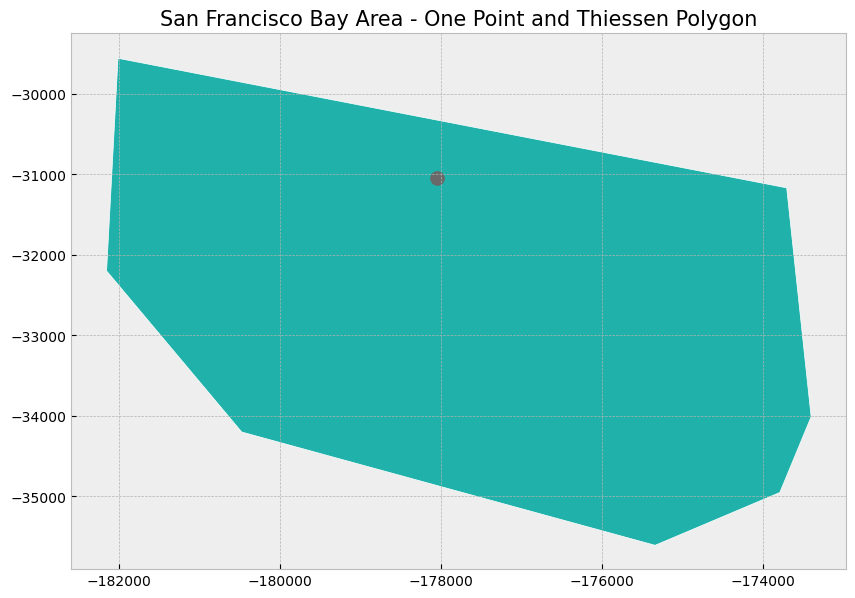

In [12]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
tp_poly_region_one.plot(ax = ax, color = 'lightseagreen', edgecolor = 'white', linewidth = 0.5)
rain_one.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 100)

# Set title
ax.set_title('San Francisco Bay Area - One Point and Thiessen Polygon', fontdict = {'fontsize': '15', 'fontweight' : '3'})

## K-Nearest Neighbors

KNN (also stylized as kNN) is a neighbor-based learning method that can be used for interpolation. Unlike the Thiessen polygons method, KNN looks for a specified number `K` of sampled points closest to an unknown point. The `K` known points can be used to predict the value (discrete or continuous) of the unknown point. [^sk_nn]

We can use the [`scikit-learn` module](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) to perform KNN analysis.

In [13]:
# Set number of neighbors to look for
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(coords_rain_train, value_rain_train)

KNeighborsRegressor(weights='distance')

Now that we have created the KNN model, we can get the in-sample r-squared value. An in-sample statistic, as suggested by its name, is calculated by using the data that were used to build the model (the "training" dataset).

In [14]:
# Generate in-sample R^2
in_r_squared_knn = knn_regressor.score(coords_rain_train, value_rain_train)
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))

KNN in-sample r-squared: 1.0


Here, the in-sample r-squared value is 100% because KNN is a "exact interpolator." For exact interpolators, estimated values for known points are exactly equal to actual values. Other methods like Kriging, shown below, are inexact interpolators. For inexact interpolators, estimated values for known points are not exactly equal to actual values. Here's a [visual of inexact versus exact interpolators](https://www.onestopgis.com/GIS-Theory-and-Techniques/Spatial-Interpolation/Elements-of-Spatial-Interpolation/posts/Types-of-Spatial-Interpolation/Image-shows-Exact-interpolation-and-Inexact-interpolation.png?__cf_chl_jschl_tk__=231d8a46e00aa6fe5352048bff01af55174b6c40-1625260397-0-ARqVOIsPHXJ9wPUqWrXKldltKnf_3GrT_RVaKb7djF6cUYCwnIzVeYww8nW4e_3GiIiCNZ15eVXmksePbUz-sKbuHtD2UsSh9OWZ4w2Y2dS_zCeIMCVRUIrYCjZEEcH722m7Y2vCDGAaA6gh1RObvtBx_3Se3gCdldO6c65zunRmX4vE0jLONpdckY6MEo4YPiyZr_11QAdPLYBWwgtl3wC2XhM5mhsmVYmInXWYTiyr35sXWVn86DedDNC2rKMnvrQGo8BuBgjskX6uf_Y3tWWpYCpyghV9s0zpygqgTQYG8rNaKJyFFQdoX--tMMEYY2AwzAI2BNmAxlGlxM07tBndOjZFgphEsU9nbFhOAB-Wji4u0wwD_N97FBKdFwsNl8bGbPSpLoiIMZ94GVZqETiD29W_lFPsiunLAt3EU2Ra-pf2QC1lCaUUhUt2aCIgHH6SnzTAm-JictSfAD4cnYolpP7D27Cj_UOGLSfo2sk4KcOH9JAG3ZGF1UCkX2fBUTivVWmuYPL4l1xaGS7e0BgKuiz_TdAbeMNkyi2TtWgMzT2sZEqf5QXZzvSwbsOVf5Z8ph6imf4gaHYhhYU87yKTDkK8PnYkbuyS3zeDWnM7hTj-Gn-LtNSYpiTjA68NZA).

Similarily, we can also get the out-of-sample r-squared value and compare the test dataset's actual values to the values as predicted by the model.

In [15]:
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_rain_test, value_rain_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_rain_test_predict_knn = knn_regressor.predict(coords_rain_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"Coordinate_Pair": coords_rain_test, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(2))

KNN out-of-sample r-squared: 0.93

Attribute Table: Testing Set Interpolated Values - KNN Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
0,"[-229633.02624581114, 40063.75429398427]",56,55.827992
1,"[-273849.3497429455, 92453.68931061402]",73,87.640078


Out-of-sample r-squared looks pretty strong!

```{tip}
If you are just interested in identifying the `k` nearest neighbors (no interpolation), use the [`NearestNeighbors()` function](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors).
```

## Kriging

Kriging is a type of interpolation that uses a semivariogram, which measures spatial autocorrelation (how similar close points are in value and how this similarity changes as distance between points increases). Thus, the semivariogram determines how much influence a known point has on an unknown point as the distance between the known point and the unknown point increases. In other words, the weight of a known point on an unknown point decreases with increasing distance, and the semivariogram determines how quickly that weight tapers with increasing distance. [^bolstad], [^esri_kriging]

For more information, see this [ArcGIS help guide on kriging](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm).

Two Python packages that can be used for kriging include `scikit-learn` and `pykrige`. The former package works best when the input data has a WGS 84 projection, so we will begin by reprojecting all of our data to that coordinate system (click the + below to show code cell).

In [16]:
'''
# Set projection to WGS 84 and reproject data
proj_wgs = 4326
counties_wgs = counties.to_crs(proj_wgs)
rainfall_wgs = rainfall.to_crs(proj_wgs)
rain_train_gdf_wgs = rain_train_gdf.to_crs(proj_wgs)
rain_test_gdf_wgs = rain_test_gdf.to_crs(proj_wgs)

# Get X and Y coordinates of rainfall points
x_rain_wgs = rainfall_wgs["geometry"].x
y_rain_wgs = rainfall_wgs["geometry"].y

# Create list of XY coordinate pairs
coords_rain_train_wgs = [list(xy) for xy in zip(rain_train_gdf_wgs["geometry"].x, rain_train_gdf_wgs["geometry"].y)]
coords_rain_test_wgs = [list(xy) for xy in zip(rain_test_gdf_wgs["geometry"].x, rain_test_gdf_wgs["geometry"].y)]

# Get minimum and maximum coordinate values of rainfall points
min_x_rain_wgs, min_y_rain_wgs, max_x_rain_wgs, max_y_rain_wgs = rain_train_gdf_wgs.total_bounds
'''

'\n# Set projection to WGS 84 and reproject data\nproj_wgs = 4326\ncounties_wgs = counties.to_crs(proj_wgs)\nrainfall_wgs = rainfall.to_crs(proj_wgs)\nrain_train_gdf_wgs = rain_train_gdf.to_crs(proj_wgs)\nrain_test_gdf_wgs = rain_test_gdf.to_crs(proj_wgs)\n\n# Get X and Y coordinates of rainfall points\nx_rain_wgs = rainfall_wgs["geometry"].x\ny_rain_wgs = rainfall_wgs["geometry"].y\n\n# Create list of XY coordinate pairs\ncoords_rain_train_wgs = [list(xy) for xy in zip(rain_train_gdf_wgs["geometry"].x, rain_train_gdf_wgs["geometry"].y)]\ncoords_rain_test_wgs = [list(xy) for xy in zip(rain_test_gdf_wgs["geometry"].x, rain_test_gdf_wgs["geometry"].y)]\n\n# Get minimum and maximum coordinate values of rainfall points\nmin_x_rain_wgs, min_y_rain_wgs, max_x_rain_wgs, max_y_rain_wgs = rain_train_gdf_wgs.total_bounds\n'

### Method 1 - Using `PyKrige`

The [`pykrige` module](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html) offers ordinary and universal kriging. It also supports various variogram models in addition to Gaussian.

PyKrige Kriging out-of-sample r-squared: 0.99

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (-229633.026 40063.754),56,55.089479
2,POINT (-244809.950 1296.393),62,61.013348


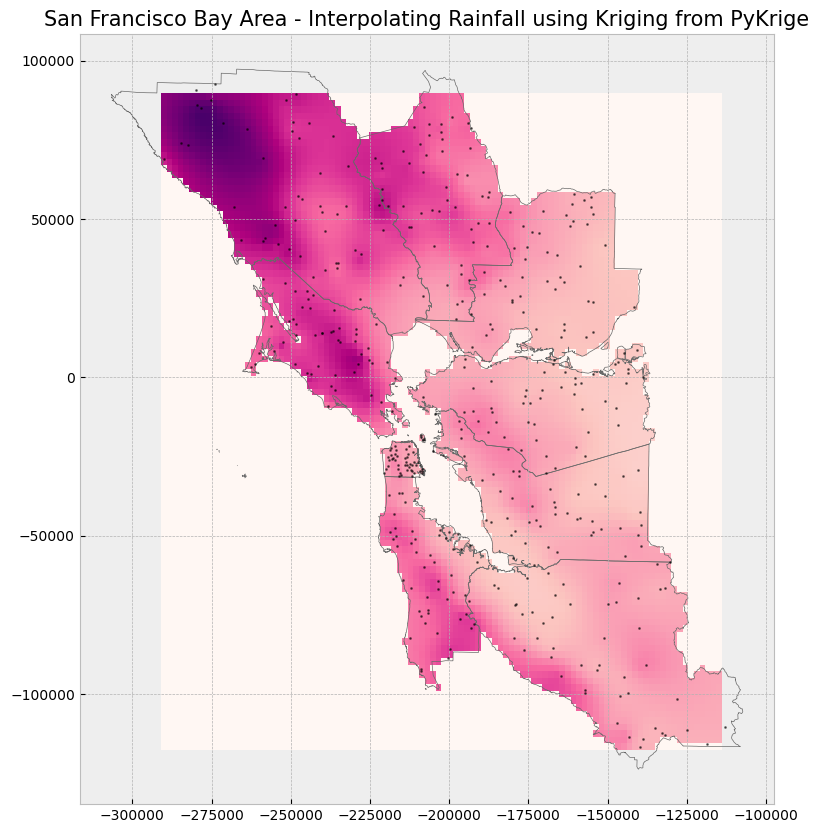

In [17]:
# Adapted from: https://geostat-framework.readthedocs.io/projects/pykrige/en/latest/examples/04_krige_geometric.html

# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_rain, max_x_rain, 100)
YY_pk_krig = np.linspace(min_y_rain, max_y_rain, 100)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    value_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_rain, max_x = max_x_rain, min_y = min_y_rain, max_y = max_y_rain,
                  proj = proj, filename = "../temp/e_bay-area-rain_pk_kriging.tif")

# Open raster
raster_pk = rasterio.open("../temp/e_bay-area-rain_pk_kriging.tif")


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
rain_test_gdf_pk_krig = rain_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
rain_test_gdf_pk_krig = rain_test_gdf_pk_krig[rain_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_rain_test_pk_krig = [list(xy) for xy in zip(rain_test_gdf_pk_krig["geometry"].x, rain_test_gdf_pk_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
rain_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_rain_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_gdf_pk_krig.Actual_Value, rain_test_gdf_pk_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(rain_test_gdf_pk_krig.head(2))


# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

### Method 2- Using `scikit-learn`

Kriging can be performed using [Gaussian processes from the `scikit-learn` module](https://scikit-learn.org/stable/modules/gaussian_process.html) (Gaussian processes is essentially equivalent to kriging). Various kernels for Gaussian processes can be specified. We will continue to use the training and testing datasets created from our KNN analysis.

In [18]:
'''
# Create a 100 by 100 cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

# Generate Gaussian Process model (can change parameters as desired)
gp = GaussianProcessRegressor(n_restarts_optimizer = 10)

# Fit kernel density estimator to coordinates and values
gp.fit(coords_rain_train_wgs, value_rain_train)

# Evaluate the model on coordinate pairs
Z_sk_krig = gp.predict(positions_sk_krig)

# Reshape the data to fit mesh grid
Z_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)
'''

'\n# Create a 100 by 100 cell mesh grid\n# Horizontal and vertical cell counts should be the same\nXX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]\n\n# Create 2-D array of the coordinates (paired) of each cell in the mesh grid\npositions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T\n\n# Generate Gaussian Process model (can change parameters as desired)\ngp = GaussianProcessRegressor(n_restarts_optimizer = 10)\n\n# Fit kernel density estimator to coordinates and values\ngp.fit(coords_rain_train_wgs, value_rain_train)\n\n# Evaluate the model on coordinate pairs\nZ_sk_krig = gp.predict(positions_sk_krig)\n\n# Reshape the data to fit mesh grid\nZ_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)\n'

Next, we can calculate our r-squared statistics and predictions.

In [19]:
'''
# Generate in-sample R^2
in_r_squared_sk_krig = gp.score(coords_rain_train_wgs, value_rain_train)
print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))

# Generate out-of-sample R^2
out_r_squared_sk_krig = gp.score(coords_rain_test_wgs, value_rain_test)
print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))

# Predict values for testing dataset
coords_rain_test_predict_sk_krig = gp.predict(coords_rain_test_wgs)

# Create dictionary holding the actual and predicted values
predict_dict_sk_krig = {"Coordinate_Pair": coords_rain_test_wgs, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_sk_krig}

# Create dataframe from dictionary
predict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")
display(predict_df_sk_krig.head(2))
'''

'\n# Generate in-sample R^2\nin_r_squared_sk_krig = gp.score(coords_rain_train_wgs, value_rain_train)\nprint("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))\n\n# Generate out-of-sample R^2\nout_r_squared_sk_krig = gp.score(coords_rain_test_wgs, value_rain_test)\nprint("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))\n\n# Predict values for testing dataset\ncoords_rain_test_predict_sk_krig = gp.predict(coords_rain_test_wgs)\n\n# Create dictionary holding the actual and predicted values\npredict_dict_sk_krig = {"Coordinate_Pair": coords_rain_test_wgs, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_sk_krig}\n\n# Create dataframe from dictionary\npredict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)\n\n# Display attribute table\nprint("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")\ndisplay(predict_df_sk_krig.head(2))\n'

Model seems like a good fit! Let's export the raster.

In [20]:
'''
# Flip array vertically and rotate 270 degrees
Z_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)

# Export raster
export_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,
                  min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,
                  proj = proj_wgs, filename = ../temp/e_bay-area-rain_sk_kriging.tif")
'''

'\n# Flip array vertically and rotate 270 degrees\nZ_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)\n\n# Export raster\nexport_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,\n                  min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,\n                  proj = proj_wgs, filename = ../temp/e_bay-area-rain_sk_kriging.tif")\n'

```{attention} The resulting raster should be clipped. Because the resulting raster covers the extent of the points in a bounding box fashion, the raster in this case covers areas that are not within the counties boundaries (such as in the ocean) where we do not have sample points. Thus, there will be interpolated values in those areas that might not make sense.
```

Finally, we import the raster, mask it to the counties boundaries, and plot the data.

In [21]:
'''
# Open raster
raster_sk = rasterio.open("../temp/e_bay-area-rain_sk_kriging.tif")

# Mask raster to counties shape
out_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')
'''

'\n# Open raster\nraster_sk = rasterio.open("../temp/e_bay-area-rain_sk_kriging.tif")\n\n# Mask raster to counties shape\nout_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)\n\n# Stylize plots\nplt.style.use(\'bmh\')\n'

### Method 2- Using `scikit-learn`

Kriging can be performed using [Gaussian processes from the `scikit-learn` module](https://scikit-learn.org/stable/modules/gaussian_process.html) (Gaussian processes is essentially equivalent to kriging). Various kernels for Gaussian processes can be specified. We will continue to use the training and testing datasets created from our KNN analysis.

In [22]:
'''
# Create a 100 by 100 cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

# Generate Gaussian Process model (can change parameters as desired)
gp = GaussianProcessRegressor(n_restarts_optimizer = 10)

# Fit kernel density estimator to coordinates and values
gp.fit(coords_rain_train_wgs, value_rain_train)

# Evaluate the model on coordinate pairs
Z_sk_krig = gp.predict(positions_sk_krig)

# Reshape the data to fit mesh grid
Z_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)
'''

'\n# Create a 100 by 100 cell mesh grid\n# Horizontal and vertical cell counts should be the same\nXX_sk_krig, YY_sk_krig = np.mgrid[min_x_rain_wgs:max_x_rain_wgs:100j, min_y_rain_wgs:max_y_rain_wgs:100j]\n\n# Create 2-D array of the coordinates (paired) of each cell in the mesh grid\npositions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T\n\n# Generate Gaussian Process model (can change parameters as desired)\ngp = GaussianProcessRegressor(n_restarts_optimizer = 10)\n\n# Fit kernel density estimator to coordinates and values\ngp.fit(coords_rain_train_wgs, value_rain_train)\n\n# Evaluate the model on coordinate pairs\nZ_sk_krig = gp.predict(positions_sk_krig)\n\n# Reshape the data to fit mesh grid\nZ_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)\n'

Next, we can calculate our r-squared statistics and predictions.

In [23]:
'''
# Generate in-sample R^2
in_r_squared_sk_krig = gp.score(coords_rain_train_wgs, value_rain_train)
print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))

# Generate out-of-sample R^2
out_r_squared_sk_krig = gp.score(coords_rain_test_wgs, value_rain_test)
print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))

# Predict values for testing dataset
coords_rain_test_predict_sk_krig = gp.predict(coords_rain_test_wgs)

# Create dictionary holding the actual and predicted values
predict_dict_sk_krig = {"Coordinate_Pair": coords_rain_test_wgs, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_sk_krig}

# Create dataframe from dictionary
predict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")
display(predict_df_sk_krig.head(2))
'''

'\n# Generate in-sample R^2\nin_r_squared_sk_krig = gp.score(coords_rain_train_wgs, value_rain_train)\nprint("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))\n\n# Generate out-of-sample R^2\nout_r_squared_sk_krig = gp.score(coords_rain_test_wgs, value_rain_test)\nprint("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))\n\n# Predict values for testing dataset\ncoords_rain_test_predict_sk_krig = gp.predict(coords_rain_test_wgs)\n\n# Create dictionary holding the actual and predicted values\npredict_dict_sk_krig = {"Coordinate_Pair": coords_rain_test_wgs, "VALUE_Actual": value_rain_test, "VALUE_Predict": coords_rain_test_predict_sk_krig}\n\n# Create dataframe from dictionary\npredict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)\n\n# Display attribute table\nprint("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")\ndisplay(predict_df_sk_krig.head(2))\n'

Model seems like a good fit! Let's export the raster.

In [24]:
'''
# Flip array vertically and rotate 270 degrees
Z_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)

# Export raster
export_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,
                  min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,
                  proj = proj_wgs, filename = ../temp/e_bay-area-rain_sk_kriging.tif")
'''

'\n# Flip array vertically and rotate 270 degrees\nZ_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)\n\n# Export raster\nexport_kde_raster(Z = Z_sk_krig, XX = XX_sk_krig, YY = YY_sk_krig,\n                  min_x = min_x_rain_wgs, max_x = max_x_rain_wgs, min_y = min_y_rain_wgs, max_y = max_y_rain_wgs,\n                  proj = proj_wgs, filename = ../temp/e_bay-area-rain_sk_kriging.tif")\n'

```{attention} The resulting raster should be clipped. Because the resulting raster covers the extent of the points in a bounding box fashion, the raster in this case covers areas that are not within the counties boundaries (such as in the ocean) where we do not have sample points. Thus, there will be interpolated values in those areas that might not make sense.
```

Finally, we import the raster, mask it to the counties boundaries, and plot the data.

In [25]:
'''
# Open raster
raster_sk = rasterio.open("../temp/e_bay-area-rain_sk_kriging.tif")

# Mask raster to counties shape
out_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_sk, ax = ax, transform = out_transform_sk, cmap = "RdPu")
ax.plot(x_rain_wgs, y_rain_wgs, 'k.', markersize = 2, alpha = 0.5)
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from Scikit-Learn', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()


# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_sk, ax = ax, transform = out_transform_sk, cmap = "RdPu")
ax.plot(x_rain_wgs, y_rain_wgs, 'k.', markersize = 2, alpha = 0.5)
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from Scikit-Learn', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()
'''

'\n# Open raster\nraster_sk = rasterio.open("../temp/e_bay-area-rain_sk_kriging.tif")\n\n# Mask raster to counties shape\nout_image_sk, out_transform_sk = rasterio.mask.mask(raster_sk, counties_wgs.geometry.values, crop = True)\n\n# Stylize plots\nplt.style.use(\'bmh\')\n\n# Plot data\nfig, ax = plt.subplots(1, figsize = (10, 10))\nshow(out_image_sk, ax = ax, transform = out_transform_sk, cmap = "RdPu")\nax.plot(x_rain_wgs, y_rain_wgs, \'k.\', markersize = 2, alpha = 0.5)\ncounties_wgs.plot(ax = ax, color = \'none\', edgecolor = \'dimgray\')\nplt.gca().invert_yaxis()\n\n# Set title\nax.set_title(\'San Francisco Bay Area - Interpolating Rainfall using Kriging from Scikit-Learn\', fontdict = {\'fontsize\': \'15\', \'fontweight\' : \'3\'})\n\n# Display plot\nplt.show()\n\n\n# Plot data\nfig, ax = plt.subplots(1, figsize = (10, 10))\nshow(out_image_sk, ax = ax, transform = out_transform_sk, cmap = "RdPu")\nax.plot(x_rain_wgs, y_rain_wgs, \'k.\', markersize = 2, alpha = 0.5)\ncounties_wgs.p

[^bolstad]: GIS Fundamentals: A First Text on Geographic Information Systems, 5th ed., Paul Bolstad
[^scipy_voronoi]: [scipy.spatial.Voronoi, SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html)
[^sk_nn]: [Nearest Neighbors, scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html)
[^esri_kriging]: [How Kriging works, Esri](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm)